# Inference of parameters with latent variables (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the epidemiological parameters as well as control parameters from the $I_\mathrm{s}$ trajectory. 

For the pre-intervention period, we infer the following parameters as well as initial conditions: 
* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

For the post-intervention period, we infer the following control parameters: 
* $a_\mathrm{W}$ fraction of work contact, 
* $a_\mathrm{S}$ fraction of social contact, 
* $a_\mathrm{O}$ fraction of other contacts 

In [1]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

## 1) Generate a trajectory
We generate a test trajectory on a population with four ages groups using UK contact matrix

In [2]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]

# rescale the population      
N /= 5e2 
Ni = N*fi 

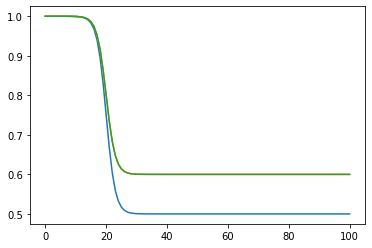

In [3]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

# Set intervention time, and the total length for the trajectory 
T_intervention = 20 # intervention time 
Tf = 100 
Nf = Tf+1

# a tanh function for intervention 
def intervention_fun(t, width=1, loc=0, aW_f=0, aS_f=0, aO_f=0):
    aW = (1-np.tanh((t-loc)/width))/2*(1-aW_f) + aW_f
    aS = (1-np.tanh((t-loc)/width))/2*(1-aS_f) + aS_f
    aO = (1-np.tanh((t-loc)/width))/2*(1-aO_f) + aO_f
    return aW, aS, aO

t = np.linspace(0, Tf, Nf) 
aW_f = 0.5 
aS_f = 0.6 
aO_f = 0.6 
width = 3
loc = T_intervention 

aW, aS, aO = intervention_fun(t, width, loc, aW_f, aS_f, aO_f)
plt.plot(t, aW)
plt.plot(t, aS)
plt.plot(t, aO)
plt.show()

In [4]:
beta  = 0.04      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 0.8               # suppresion of contact by symptomatics


# initial conditions    
Is0 = np.ones(M)*10
Ia0 = np.ones((M))*2
R0  = np.zeros((M))
S0  = Ni - (Ia0 + Is0 + R0)

# contact matrix 
contactMatrix = generator.intervention_custom_temporal(intervention_fun, 
                                                       width=width, loc=loc, 
                                                       aW_f=aW_f, aS_f=aS_f, aO_f=aO_f)

parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)

# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
np.save('cal_lat_SIR_traj.npy', data['X'])

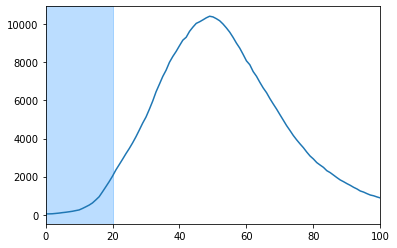

In [5]:
# plot the number of infected people 
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.axvspan(0, T_intervention, 
           label='Pre intervention',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.show() 

## 2) Infer the parameters and initial conditions for the pre-intervention trajectory

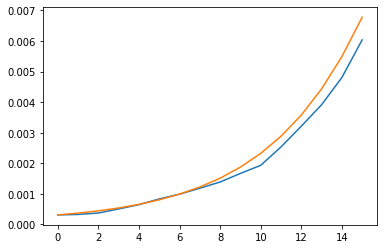

In [6]:
Tf_initial = 15 # truncate to only getting the pre-intervention trajectory 
Nf_initial = Tf_initial+1

x = (np.load('cal_lat_SIR_traj.npy')).astype('float')
x = (x/N)[:Nf_initial]

# a filter that yields the Is only 
fltr = np.kron([0, 0, 1],np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0 = x[0] 

steps = 8 # number of steps 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# Check the deterministic simulation against stochstic simulations with the same parameters and initial conditons 
# They are likely to be different due to the inherent stochasticity of the model 
contactMatrix = generator.intervention_custom_temporal(intervention_fun, 
                                                       width=width, loc=loc, 
                                                       aW_f=aW_f, aS_f=aS_f, aO_f=aO_f)

# generator.constant_contactMatrix()
det_model = estimator.make_det_model(parameters)
estimator.set_det_method('LSODA')
xm = estimator.integrate(x[0], 0, Tf_initial, Nf_initial, det_model, contactMatrix)
t = np.linspace(0, Tf_initial, Nf_initial)
plt.plot(t, np.sum(x[:,2*M:3*M], axis=1))
plt.plot(t, np.sum(xm[:,2*M:3*M], axis=1))
plt.show()

In [7]:
# Initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# Compute -log_p for the original (correct) parameters 
# This gives an estimate of the final -logp we expect from the optimisation scheme 
start_time = time.time() 
parameters = {'alpha': alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
contactMatrix = generator.constant_contactMatrix() # set contact matrix to be constant 
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_initial, Nf_initial, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-532.4762928345857
0.1650989055633545


In [8]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3 

alpha_g = 0.15
alpha_std = 0.1
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.02
beta_std = 0.1 
beta_bounds = (eps, 1)

gIa_g = 0.13
gIa_std = 0.05 # small stds for rate of recovery (can obtain from clinical data)
gIa_bounds = (0.1, 0.3)

gIs_g = 0.13
gIs_std = 0.05 # small stds for rate of recovery (can obtain from clinical data)
gIs_bounds = (0.1, 0.3) 

# not inferred 
fsa_g = 0.8

Ia0_g = (Ia0+3)/N
Ia_std = Ia0_g*2
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0-10)/N
S_std = Ia_std*2
bounds_for_S = np.tile([0.1/N, 1], M).reshape(M, 2)

# Optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# Set up bounds, guess and stds for the rest of the params
# set up bounds, guess and stds for the rest of the params 
keys = ['alpha', 'beta', 'gIa', 'gIs']
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, 
                  *S0_g, *Ia0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, 
                 *S_std, *Ia_std])

# set up fltr for initial conditions because they are constraint by the observed 
init_fltr = np.repeat([True, True, False], M)

start_time = time.time()
estimator.set_det_method('RK2')
estimator.set_lyapunov_method('euler')
params = estimator.latent_infer_parameters(keys, init_fltr, guess, stds, obs, fltr, Tf_initial, Nf_initial, 
                                    contactMatrix, bounds, 
                                    tangent=False,
                                    global_max_iter=15, global_atol=1, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 12 (seed=217997950, Thu May 28 21:18:28 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.603267809499027e+04 1.0e+00 9.66e-01  7e-05  1e-01 0:00.8
    2     32 4.903851154124779e+02 1.2e+00 1.01e+00  8e-05  1e-01 0:01.6
    3     48 -5.997411685775293e+02 1.3e+00 1.05e+00  8e-05  1e-01 0:02.6
    6     96 -5.945717819409853e+02 1.6e+00 1.04e+00  8e-05  1e-01 0:05.0
Optimal value (global minimisation):  -599.7411685775293
Starting local minimisation...
Optimal value (local minimisation):  -610.3063237625687
15.789685010910034


In [9]:
# save the parameters 
np.save('SIR_cal_lat_param.npy', params)

In [10]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

params = np.load('SIR_cal_lat_param.npy')
best_estimates = estimator.fill_params_dict(keys, params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, Ia0, Is0)

partial_inits = params[len(keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
print('\n Inferred initial conditons: ') 
print((x0*N).astype('int'))
print('R initial = ', N*(fi - np.sum(x0.reshape((3, M)), axis=0)))

True parameters
{'alpha': 0.2, 'beta': 0.04, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8}

 Best estimates
{'alpha': 0.07251632739095676, 'beta': 0.0380059267342443, 'gIa': 0.12469019724121941, 'gIs': 0.13061286603117858, 'fsa': array([0.8, 0.8, 0.8, 0.8])}

 True initial conditions: 
[31256.886 35656.366 35514.088 25747.864] [2. 2. 2. 2.] [10. 10. 10. 10.]

 Inferred initial conditons: 
[31228 35643 35504 25746     2     0     0     2    10    10    10    10]
R initial =  [27.07360777 14.92793841 10.47735929  1.19982943]


In [11]:
logp = estimator.minus_logp_red(best_estimates, x0, obs[1:], fltr, Tf_initial, Nf_initial, contactMatrix, tangent=False)
print(logp)

-532.0180063258726


### Check the inferred trajectory against the true trajectory for pre-intervention

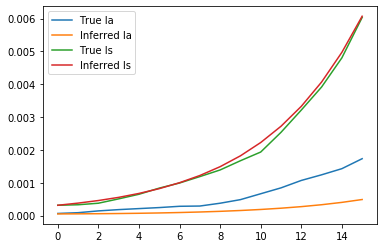

In [12]:
x = np.load('cal_lat_SIR_traj.npy')/N

# set params for estimate
estimator.set_params(best_estimates)

# make det_model and contactMatrix 
det_model = estimator.make_det_model(best_estimates)

# generate the deterministic trajectory 
estimator.set_det_method('LSODA')
x_det = estimator.integrate(x0, 0, Tf_initial, Nf_initial, det_model, contactMatrix)
plt.plot(np.sum(x[:Nf_initial,M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:Nf_initial,2*M:3*M], axis=1), label='True Is')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.legend()
plt.show()

Quite good at inferring Is (which it can see), not so good at inferring Ia (which it cannot see)

## 3) Infer the control parameters 
We infer the control parameters, including the location of change, width and the final aW, aS, aO 

In [14]:
# Test the -logp for the correct control parameters 

# get the trajectory 
x = np.load('cal_lat_SIR_traj.npy')/N
x = x[:40]
obs = np.einsum('ij,kj->ki', fltr, x)
Nf = x.shape[0] 
Tf = Nf-1 


contactMatrix = generator.intervention_custom_temporal(intervention_fun, 
                                                       width=width, loc=loc, 
                                                       aW_f=aW_f, aS_f=aS_f, aO_f=aO_f)
# compute -log_p 
logp = estimator.minus_logp_red(best_estimates, x0, obs[1:], fltr, Tf, Nf, contactMatrix)
print(logp) 

-1249.8934131668711


In [15]:
width_g = 3
width_std = 2 
width_bounds = [1, 5]

loc_g = T_intervention-1 
loc_std = 2 
loc_bounds = [T_intervention-5, T_intervention+5]

aW_g = 0.6 
aW_std = 0.1 
aW_bounds = [0.1, 0.8]

aS_g = 0.5
aS_std = 0.1 
aS_bounds = [0.1, 0.8]

aO_g = 0.5
aO_std = 0.1 
aO_bounds = [0.1, 0.8]

keys = ['width', 'loc', 'aW_f', 'aS_f', 'aO_f']
guess = np.array([width_g, loc_g, aW_g, aS_g, aO_g])
stds = np.array([width_std, loc_std, aW_std, aS_std, aO_std])
bounds = np.array([width_bounds, loc_bounds, aW_bounds, aS_bounds, aO_bounds])

start_time = time.time() 
estimator.set_det_method('LSODA') # slower but performs better for exponential decay (near the end of the pandemic)
estimator.set_lyapunov_method('RK45')
control_params = estimator.latent_infer_control(keys, guess, stds, x0, obs, fltr, Tf, Nf, generator, bounds,
                                         intervention_fun=intervention_fun, tangent=False,
                                 global_max_iter=20, verbose=True)
end_time = time.time()

print(control_params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 5 (seed=233448810, Thu May 28 21:19:40 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.245004985324385e+03 1.0e+00 9.89e-01  1e-01  2e+00 0:03.5
    2     32 -1.243855426169125e+03 1.4e+00 9.97e-01  1e-01  2e+00 0:06.7
    3     48 -1.248281340751243e+03 1.7e+00 8.95e-01  8e-02  2e+00 0:10.2
    4     64 -1.247486886856911e+03 1.6e+00 8.64e-01  7e-02  2e+00 0:13.3
    6     96 -1.252595731594048e+03 1.7e+00 7.24e-01  5e-02  1e+00 0:20.4
    8    128 -1.250284386560010e+03 2.0e+00 5.23e-01  3e-02  9e-01 0:27.0
   10    160 -1.252177449294173e+03 2.4e+00 4.20e-01  3e-02  6e-01 0:33.4
   13    208 -1.252276344493763e+03 2.3e+00 3.39e-01  2e-02  4e-01 0:43.0
   16    256 -1.252862664168486e+03 2.4e+00 2.91e-01  2e-02  3e-01 0:52.1
   19    304 -1.252956911947455e+03 2.4e+00 2.02e-01  9e-03  2e-01 1:01.2
Optimal value (global minimisation):  -1253.0355863581917
Star

In [22]:
true_control_params = {'width': width, 'loc': T_intervention, 'aW_f': aW_f, 'aS_f': aS_f, 'aO_f': aO_f}
inferred_control_params = {k:control_params[i] for (i, k) in enumerate(keys)}

print('True control params:')
print(true_control_params)

print('\n Inferred control params:')
print(inferred_control_params)

True control params:
{'width': 3, 'loc': 20, 'aW_f': 0.5, 'aS_f': 0.6, 'aO_f': 0.6}

 Inferred control params:
{'width': 2.4929271857413657, 'loc': 20.54279597977932, 'aW_f': 0.547731332114648, 'aS_f': 0.590484030623763, 'aO_f': 0.551822533598774}


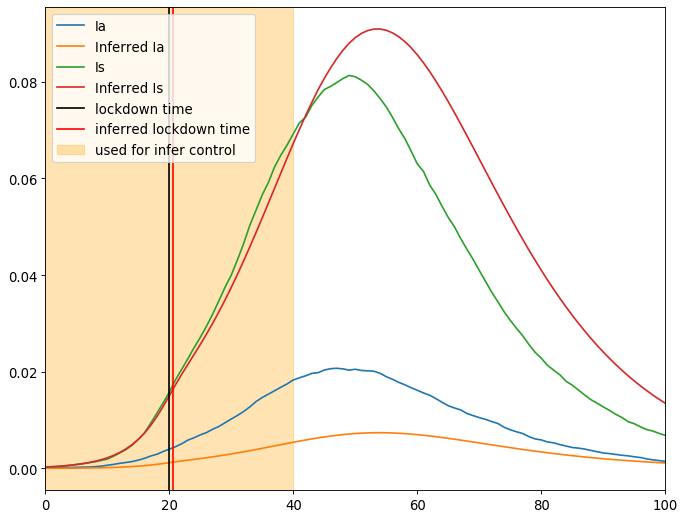

In [24]:
# compare the true trajectory with the 
Tf = 100 
Nf = Tf + 1 

inferred_contactMatrix = generator.intervention_custom_temporal(intervention_fun, 
                                                 width=control_params[0], 
                                                 loc=control_params[1], 
                                                 aW_f=control_params[2], 
                                                 aS_f=control_params[3],
                                                 aO_f=control_params[4])
det_model = estimator.make_det_model(best_estimates)
x_det_control = estimator.integrate(x0, 0, Tf, Nf, det_model, inferred_contactMatrix)
x = np.load('cal_lat_SIR_traj.npy')/N
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
plt.plot(np.sum(x[:,M:2*M], axis=1), label='Ia')
plt.plot(np.sum(x_det_control[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:,2*M:3*M], axis=1), label='Is')
plt.plot(np.sum(x_det_control[:, 2*M:3*M], axis=1), label='Inferred Is')
plt.axvline(x=T_intervention, label='lockdown time', color='black')
plt.axvline(x=control_params[1], label='inferred lockdown time', color='red')
plt.axvspan(0, 40, 
           label='used for infer control',
           alpha=0.3, color='orange')
plt.xlim([0, Tf])
plt.legend()
plt.show()